# Figure 9

In [1]:
# datasets/analysis
import numpy as np
import xarray as xr

# cosima
import cosima_cookbook as cc

# plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cmocean.cm as cmo

In [2]:
import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [3]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40779,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:41935,Total threads: 4
Dashboard: /proxy/43413/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:38671,


In [4]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

In [5]:
ds = xr.open_dataset('/g/data/e14/hd4873/access-om2-01/project03_misc_data/zonal_transport/ASC_transports_V2.nc')
spd_expt = xr.open_dataset('/g/data/e14/hd4873/access-om2-01/project03_misc_data/speed/upper_ocean_0-500m_speed_ssp245mw.nc')
spd_cntl = xr.open_dataset('/g/data/e14/hd4873/access-om2-01/project03_misc_data/speed/upper_ocean_0-500m_speed_control.nc')

# zonal_lats = [-65.75,  -66.05, -64.08, -64.95, -65.32, -65.85, -71.95, -72.97, -76, -74.5, -74.1, -72.65, -71.05, -69.32, -72.15, -74.25, -70.1, -69.98,-70.02, -66.45, -66.8, -66.85]
# zonal_lons = [-276.85,  -273.15, -260.35, -256.45, -247.95, -213.35, -187.35, -181.15, -166.55, -142.95, -138.05, -121.95, -105.55, -80.95, -51.05, -32.75, -4.35, 5.5, 22.95, 48.15, 65.25, 76, ]

In [6]:
# database for ssp585_wind_thermal simulation
session_dir = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/databases/SSP2100_experiments_nodaily.db.db'
expt_session = cc.database.create_session(session_dir)
ssp585 = '01deg_jra55v13_ryf9091_ssp585'
ssp585mw = '01deg_jra55v13_ryf9091_ssp585_mw'
ssp245 = '01deg_jra55v13_ryf9091_ssp245'
ssp245mw = '01deg_jra55v13_ryf9091_ssp245_mw'

expts = [control, ssp245, ssp245mw, ssp585, ssp585mw]
colours = ['k', '#92c5de', '#0571b0', '#fdae61', '#ca0020', ]
ht_so = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=slice(None, -59)).load()

#### Cumulative sum

In [7]:
data_directory = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/zonal_transport/'
zonal_lons = np.array([-242.15, -166.55, -92.95, -32.75, 65.25])

lat_n = [-62, -71, -66.9, -66.5, -60]
lat_n_2500 = np.zeros(5)
lat_n_2000 = np.zeros(5)
lat_isobath = np.zeros(5)
lat_630m = np.zeros(5)
lat_n_lim = [-75, -75, -75, -75, -75]
lat_s = np.zeros(5)
sv_min = np.zeros(5)
sv_max = np.zeros(5)

In [8]:
acoc_sv = xr.DataArray(np.zeros((5,5)), 
                       coords={'longitude': zonal_lons, 
                               'experiment': ['control','ssp245','ssp245mw','ssp585','ssp585mw']}, 
                       dims=['longitude','experiment'])
asc_sv = xr.DataArray(np.zeros((5,5)), 
                       coords={'longitude': zonal_lons, 
                               'experiment': ['control','ssp245','ssp245mw','ssp585','ssp585mw']}, 
                       dims=['longitude','experiment'])
asc_big_sv = xr.DataArray(np.zeros((5,5)), 
                       coords={'longitude': zonal_lons, 
                               'experiment': ['control','ssp245','ssp245mw','ssp585','ssp585mw']}, 
                       dims=['longitude','experiment'])

In [9]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90


def figure_setup():

    plt.rcParams.update({'font.size': 10})
    fig = plt.figure(tight_layout=True, figsize=(14.5,10.5))
    gs = gridspec.GridSpec(2, 5, wspace=0.3, hspace=0.07, height_ratios=[1,1])
    
    ax1 = fig.add_subplot(gs[0, :], projection=ccrs.Mercator(central_longitude=-100), aspect=2)
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
    ax4 = fig.add_subplot(gs[1, 2])
    ax5 = fig.add_subplot(gs[1, 3])
    ax6 = fig.add_subplot(gs[1, 4])
    axes = [ax2, ax3, ax4, ax5, ax6]

    return fig, ax1, axes
    

def colorbar_vert(cb, axes, label):
    fontsize=16
    cbaxes = fig.add_axes(axes)
    cbar = plt.colorbar(cb, cax = cbaxes, orientation = 'vertical',extend = 'both')
    cbar.set_label(label,fontsize=fontsize,labelpad=2)
    cbar.ax.tick_params(labelsize=fontsize)
    

def label_panels(fig, axes1, axes2):

    axes1.text(0.88, 0.1, 'SSP245-MW - CTRL', transform=ax1.transAxes, fontsize=16,
             verticalalignment='center', ha='center', color='dimgrey', fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='gainsboro', edgecolor='w', alpha=0.7, pad=0.3))
    
    axes1.text(-275, -78.5, 'A',  c='k', fontsize=30, fontweight='bold', transform = ccrs.PlateCarree())
    axes2[0].text(0.03, 1.01, 'B',  c='k', fontsize=22, fontweight='bold', transform=axes2[0].transAxes)
    axes2[1].text(0.03, 1.01, 'C',  c='k', fontsize=22, fontweight='bold', transform=axes2[1].transAxes)
    axes2[2].text(0.03, 1.01, 'D',  c='k', fontsize=22, fontweight='bold', transform=axes2[2].transAxes)
    axes2[3].text(0.03, 1.01, 'E',  c='k', fontsize=22, fontweight='bold', transform=axes2[3].transAxes)
    axes2[4].text(0.03, 1.01, 'F',  c='k', fontsize=22, fontweight='bold', transform=axes2[4].transAxes)
    
    axes2[0].set_ylabel('Latitude (\u00b0S)', fontsize=16)
    axes2[2].set_xlabel('Cumulative Transport (Sv)', fontsize=16)

    # label transects
    labels=['B','C','D','E','F']
    for i, lon in enumerate(zonal_lons):
        axes1.plot([lon, lon],[lat_s[i], lat_n_lim[i]], c='fuchsia', lw=3, transform = ccrs.PlateCarree()) 
        if i == 1:
            axes1.text(lon+7, lat_s[i]-0.2, labels[i],  c='k', fontsize=14, ha='center', fontweight='bold', 
                     bbox=dict(facecolor='w', edgecolor='k', boxstyle='round', pad=0.1, alpha=0.95), transform=ccrs.PlateCarree())
        elif i == 3:
            axes1.text(lon, lat_s[i]-0.8, labels[i],  c='k', fontsize=14, ha='center', fontweight='bold', 
                     bbox=dict(facecolor='w', edgecolor='k', boxstyle='round', pad=0.1, alpha=0.95), transform=ccrs.PlateCarree())
        elif i == 2:
            axes1.text(lon, lat_s[i]-1.1, labels[i],  c='k', fontsize=14, ha='center', fontweight='bold', 
                     bbox=dict(facecolor='w', edgecolor='k', boxstyle='round', pad=0.1, alpha=0.95), transform=ccrs.PlateCarree())
        else:
            axes1.text(lon, lat_s[i]-1.4, labels[i],  c='k', fontsize=14, ha='center', fontweight='bold', 
                     bbox=dict(facecolor='w', edgecolor='k', boxstyle='round', pad=0.1, alpha=0.95), transform=ccrs.PlateCarree())


def plot_speed_anomaly(axes, ds, cmap=cmo.delta_r):

    anomaly = ds.speed - spd_cntl.speed
    cb = axes.pcolormesh(ds.xu_ocean, ds.yu_ocean, anomaly, 
                         cmap=cmap, vmin=-0.1, vmax=0.1, transform=ccrs.PlateCarree())
    axes.pcolormesh(ht.xt_ocean, land_mask_lat, land_mask_masked, cmap='Greys_r', 
                   vmin=0, vmax=2, transform=ccrs.PlateCarree())
    axes.contour(ht.xt_ocean, ht.yt_ocean, ht, levels=[630,1000,2000],
                 colors=['grey','k','k'], linewidths=[0.6, 1, 0.6], transform=ccrs.PlateCarree())
    axes.set_extent([-180, 180, -79,-59], crs=ccrs.PlateCarree())
    gl = axes.gridlines(color='lightgrey', linestyle='-', alpha=0.2, draw_labels=True)
    gl.xlabels_bottom = False

    return cb

def add_transport_values(axes):

    for i, ax in enumerate(axes):
        yval = 0.2
        yval_2 = 0.48
        for e, expt in enumerate(expts):
            acoc_text_val = np.round(acoc_sv.isel(longitude=i).isel(experiment=e).values, decimals=1)
            ax.text(0.06, yval,f'{acoc_text_val} Sv', zorder=4,
                    c=colours[e], fontsize=11, transform=ax.transAxes)
            asc_text_val = np.round(asc_sv.isel(longitude=i).isel(experiment=e).values, decimals=1)
            ax.text(0.06, yval_2,f'{asc_text_val} Sv', zorder=4,
                    c=colours[e], fontsize=11, transform=ax.transAxes)
            yval = yval-0.04
            yval_2 = yval_2-0.04
    
        ax.text(0.06, 0.25, f'CC', c='k', fontweight='bold',fontsize=11, zorder=4, transform=ax.transAxes)
        ax.text(0.06, 0.53, f'ASC', c='k', fontweight='bold',fontsize=11, zorder=4, transform=ax.transAxes)
        rect = patches.FancyBboxPatch([0.06, 0.05],0.34,0.21,boxstyle=patches.BoxStyle("Round", pad=0.03), 
                                   facecolor='w',edgecolor='grey',alpha=0.8, transform=ax.transAxes, zorder=3)
        ax.add_patch(rect)
        rect = patches.FancyBboxPatch([0.06, 0.33],0.34,0.21,boxstyle=patches.BoxStyle("Round", pad=0.03), 
                                   facecolor='w',edgecolor='grey',alpha=0.8, transform=ax.transAxes, zorder=3)
        ax.add_patch(rect)

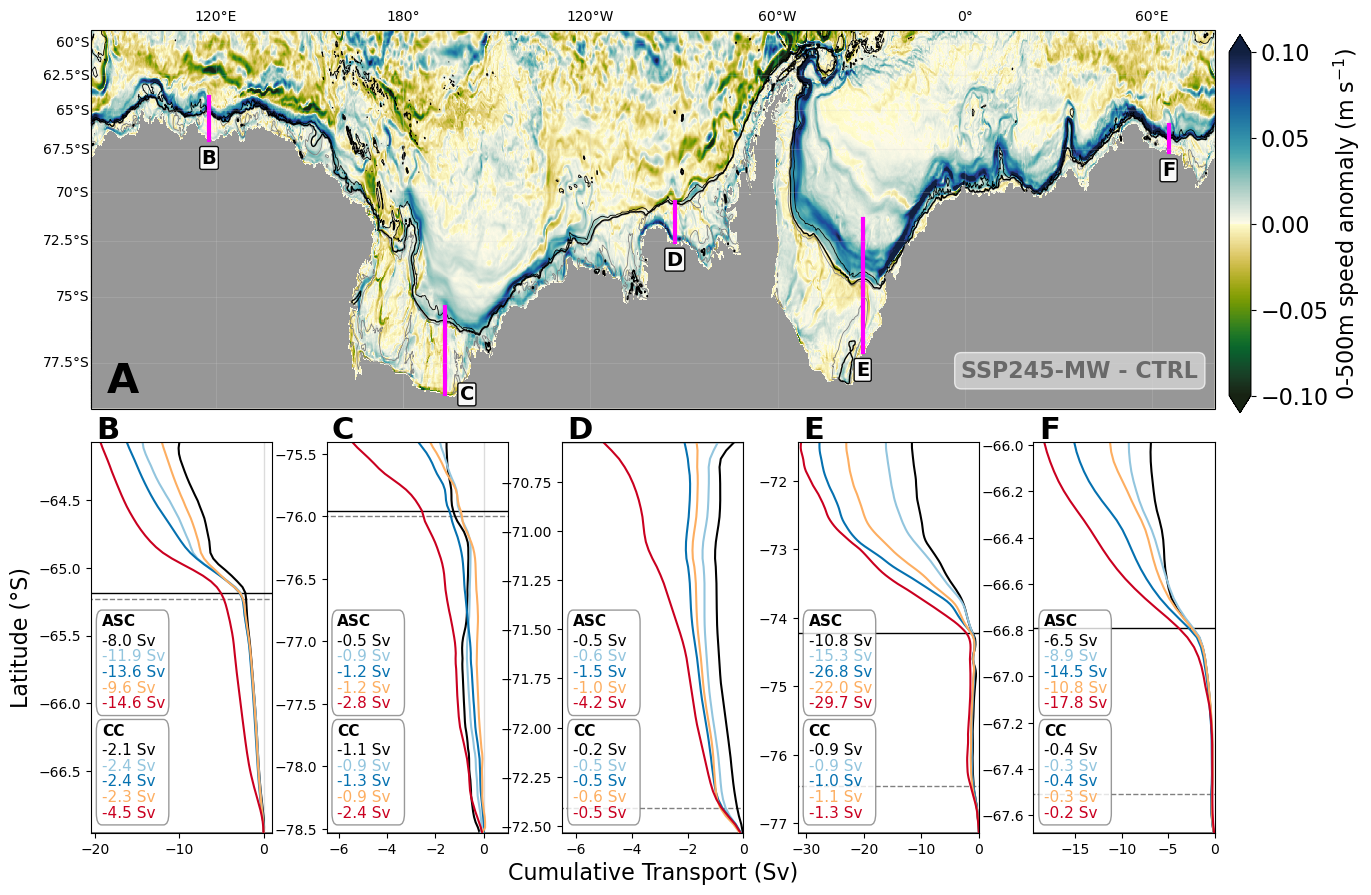

CPU times: user 2min 8s, sys: 25.3 s, total: 2min 33s
Wall time: 2min 7s


In [10]:
%%time
fig, ax1, axes = figure_setup()

for i, lon in enumerate(zonal_lons):
    # plot transport line 
    axes[i].plot([0,0],[-80,-60], lw=1, ls='-', c='gainsboro')

    # find indices and plot lines
    ocean_index = np.where(ht_so.sel(xt_ocean=lon, method='nearest') > 0)[0][0]
    isobath_index = np.where(ht_so.sel(xt_ocean=lon, method='nearest') > 1000)[0][0]
    isobath_630_index = np.where(ht_so.sel(xt_ocean=lon, method='nearest') > 630)[0][0]
    axes[i].plot([-50,10],[ht_so.yt_ocean[ocean_index], ht_so.yt_ocean[ocean_index]], lw=2, ls='-', c='dimgrey')
    axes[i].plot([-50,10],[ht_so.yt_ocean[isobath_index], ht_so.yt_ocean[isobath_index]], lw=1, ls='-', c='k')
    axes[i].plot([-50,10],[ht_so.yt_ocean[isobath_630_index], ht_so.yt_ocean[isobath_630_index]], lw=1, ls='--', c='grey')
    
    # set southern limit (start of ocean)
    lat_s[i] = ht_so.yt_ocean[ocean_index].values

    # plot cumulative transport
    for e, expt in enumerate(expts):
        ds = xr.open_dataset(data_directory + f'u_trans_transect_{expt}_{lon}.nc')
        axes[i].plot(ds.u_trans.mean('time').cumsum(), ds.yt_ocean, c=colours[e], zorder=2)

        if e == 0:# set northern limit based on where transport switches back to zero in control
                    zero_index = np.where(ds.u_trans.mean('time').isel(yt_ocean=slice(isobath_index, None)) > 0.)[0][0]
                    lat_n_lim[i] = ht_so.yt_ocean[isobath_index+zero_index].values
            
        # extract min and max values
        min_val = np.floor(ds.u_trans.mean('time').sel(yt_ocean=slice(None, lat_n_lim[i])).cumsum().min())
        max_val = np.ceil(ds.u_trans.mean('time').sel(yt_ocean=slice(None, lat_n_lim[i])).cumsum().max())
        if min_val < sv_min[i]:
            sv_min[i] = min_val
        if max_val > sv_max[i]:
            sv_max[i] = max_val
        # ACOC is cumulatively summed out to 630 m 
        acoc_sv[i,e] = ds.u_trans.mean('time').isel(yt_ocean=slice(None, isobath_630_index)).cumsum().values[-1]
        # ASC is cumulatively summed from 630m to where transport N of 1000m isobath first reverses
        asc_sv[i,e] = ds.u_trans.mean('time').isel(yt_ocean=slice(isobath_630_index, isobath_index+zero_index)).cumsum().values[-1]
                
    # set xaxis and yaxis limits
    axes[i].set_xlim([sv_min[i]-0.5, sv_max[i]])
    axes[i].set_ylim([lat_s[i], lat_n_lim[i]])

# Plot speed anomaly (upper 500 m) and add colour bar
cb = plot_speed_anomaly(ax1, spd_expt, cmap=cmo.delta_r)
colorbar_vert(cb, [0.91, 0.51, 0.015, 0.36], '0-500m speed anomaly (m s$^{-1}$)')    

label_panels(fig, ax1, axes)

add_transport_values(axes)

# save to file
save_flag = 0
figfile = f'../figs/Fig09_transport_cumulative.jpg'
if save_flag == 1:
    fig.savefig(figfile, bbox_inches='tight', dpi=300)

plt.show()